####  Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda

import gym
import argparse
import numpy as np

import tqdm
import collections
import matplotlib.pyplot as plt
from gym.envs.registration import register

#### Load simulator and define custom reward --can't rerun without restarting kernel--

In [2]:
def custom_reward(BG_last_hour):
    if BG_last_hour[-1] > 180:
        return -1
    elif BG_last_hour[-1] < 70:
        return -2
    else:
        return 1

register(
    id='simglucose-adolescent2-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'adolescent#002','reward_fun': custom_reward})

#### Hyperparameters

In [3]:
## Reference values
# gamma = 0.99
# update_interval = 5
# actor_lr = 0.0005
# critic_lr = 0.001

class Hyperparameters:
    def __init__(self):
        self.gamma = 0.99
        self.update_interval = 5
        self.actor_lr = 0.01
        self.critic_lr = 0.01
        
args = Hyperparameters()

#### Define Actor, Critic, Agent 

In [6]:
tf.keras.backend.set_floatx('float64')

class Actor:
    def __init__(self, state_dim, action_dim, action_bound, std_bound):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.std_bound = std_bound
        self.model = self.create_model()
        self.opt = tf.keras.optimizers.Adam(args.actor_lr)

    def create_model(self):
        state_input = Input((self.state_dim,))
        dense_1 = Dense(32, activation='relu')(state_input)
        dense_2 = Dense(32, activation='relu')(dense_1)
        out_mu = Dense(self.action_dim, activation='tanh')(dense_2)  
        mu_output = Lambda(lambda x: x * self.action_bound)(out_mu)
        std_output = Dense(self.action_dim, activation='softplus')(dense_2)
        return tf.keras.models.Model(state_input, [mu_output, std_output])

    def get_action(self, state):
        state = np.reshape(state, [1, self.state_dim])
        mu, std = self.model.predict(state)
        mu, std = mu[0], std[0]
        return np.random.normal(mu, std, size=self.action_dim)

    def log_pdf(self, mu, std, action):
        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        var = std ** 2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / \
            var - 0.5 * tf.math.log(var * 2 * np.pi)
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)

    def compute_loss(self, mu, std, actions, advantages):
        log_policy_pdf = self.log_pdf(mu, std, actions)
        loss_policy = log_policy_pdf * advantages
        return tf.reduce_sum(-loss_policy)

    def train(self, states, actions, advantages):
        with tf.GradientTape() as tape:
            mu, std = self.model(states, training=True)
            loss = self.compute_loss(mu, std, actions, advantages)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss


class Critic:
    def __init__(self, state_dim):
        self.state_dim = state_dim
        self.model = self.create_model()
        self.opt = tf.keras.optimizers.Adam(args.critic_lr)

    def create_model(self):
        return tf.keras.Sequential([
            Input((self.state_dim,)),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1, activation='linear')
        ])

    def compute_loss(self, v_pred, td_targets):
        mse = tf.keras.losses.MeanSquaredError()
        return mse(td_targets, v_pred)

    def train(self, states, td_targets):
        with tf.GradientTape() as tape:
            v_pred = self.model(states, training=True)
            assert v_pred.shape == td_targets.shape
            loss = self.compute_loss(v_pred, tf.stop_gradient(td_targets))
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss


class Agent:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.shape[0]
        self.action_bound = self.env.action_space.high[0]
        self.std_bound = [1e-2, 1.0]
        
        self.actor = Actor(self.state_dim, self.action_dim,
                           self.action_bound, self.std_bound)
        self.critic = Critic(self.state_dim)

    def td_target(self, reward, next_state, done):
        if done:
            return reward
        v_value = self.critic.model.predict(
            np.reshape(next_state, [1, self.state_dim]))
        return np.reshape(reward + args.gamma * v_value[0], [1, 1])

    def advatnage(self, td_targets, baselines):  
        return td_targets - baselines
    # Change name advantage 

    def list_to_batch(self, list):
        batch = list[0]
        for elem in list[1:]:
            batch = np.append(batch, elem, axis=0)
        return batch

    def train(self, max_episodes=10000):
        for ep in range(max_episodes):
            state_batch = []
            action_batch = []
            td_target_batch = []
            advatnage_batch = []
            episode_reward, done = 0, False

            state = self.env.reset()

            while not done:
                self.env.render()
                action_unclipped = self.actor.get_action(state)
                action = np.clip(action_unclipped,0, self.action_bound) 

                next_state, reward, done, _ = self.env.step(action)

                state = np.reshape(state, [1, self.state_dim])
                action = np.reshape(action, [1, self.action_dim])
                next_state = np.reshape(next_state, [1, self.state_dim])
                reward = np.reshape(reward, [1, 1])
                print("BG: ", np.round(state[0][0],1), "    Insulin:",  np.round(action[0][0],1), "    (Proposal):", np.round(action_unclipped[0],1))

                td_target = self.td_target((reward+8)/8, next_state, done)
                advantage = self.advatnage(
                    td_target, self.critic.model.predict(state))

                state_batch.append(state)
                action_batch.append(action)
                td_target_batch.append(td_target)
                advatnage_batch.append(advantage)

                if len(state_batch) >= args.update_interval or done:
                    states = self.list_to_batch(state_batch)
                    actions = self.list_to_batch(action_batch)
                    td_targets = self.list_to_batch(td_target_batch)
                    advantages = self.list_to_batch(advatnage_batch)

                    actor_loss = self.actor.train(states, actions, advantages)
                    critic_loss = self.critic.train(states, td_targets)

                    state_batch = []
                    action_batch = []
                    td_target_batch = []
                    advatnage_batch = []

                episode_reward += reward[0][0]
                state = next_state[0]

            print('EP{} EpisodeReward={}'.format(ep, episode_reward))

#### Initialize

In [7]:
env_name = 'simglucose-adolescent2-v0'
env = gym.make(env_name)
agent = Agent(env)

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


#### Test 

In [ ]:
#Issue here only resetting simulator changes initial state
env.seed(441)
env.reset()

In [ ]:
actione = np.array(30.0)

In [ ]:
env.step(actione)

#### Train Environment

BG:  150.8     Insulin: 0.0     (Proposal): -25.3
BG:  150.7     Insulin: 0.0     (Proposal): -60.8
BG:  150.6     Insulin: 0.0     (Proposal): -44.2
BG:  151.9     Insulin: 0.0     (Proposal): -0.8
BG:  154.1     Insulin: 0.0     (Proposal): -12.8
BG:  156.9     Insulin: 0.0     (Proposal): -19.5
BG:  159.8     Insulin: 0.0     (Proposal): -8.6
BG:  162.4     Insulin: 0.0     (Proposal): -32.4
BG:  164.5     Insulin: 0.0     (Proposal): -29.7
BG:  165.5     Insulin: 0.0     (Proposal): -8.9
BG:  165.5     Insulin: 12.3     (Proposal): 12.3
BG:  164.6     Insulin: 30.0     (Proposal): 88.2
BG:  163.1     Insulin: 21.8     (Proposal): 21.8
BG:  161.3     Insulin: 30.0     (Proposal): 44.2
BG:  159.4     Insulin: 19.8     (Proposal): 19.8
BG:  157.3     Insulin: 13.7     (Proposal): 13.7
BG:  154.7     Insulin: 19.3     (Proposal): 19.3
BG:  151.1     Insulin: 7.3     (Proposal): 7.3
BG:  146.5     Insulin: 22.7     (Proposal): 22.7
BG:  140.9     Insulin: 30.0     (Proposal): 46.4
BG:  

BG:  150.8     Insulin: 26.1     (Proposal): 26.1
BG:  150.7     Insulin: 30.0     (Proposal): 55.6
BG:  150.6     Insulin: 30.0     (Proposal): 46.2
BG:  151.8     Insulin: 29.8     (Proposal): 29.8
BG:  153.7     Insulin: 11.0     (Proposal): 11.0
BG:  155.5     Insulin: 30.0     (Proposal): 41.9
BG:  156.4     Insulin: 12.2     (Proposal): 12.2
BG:  155.7     Insulin: 20.3     (Proposal): 20.3
BG:  153.0     Insulin: 20.7     (Proposal): 20.7
BG:  147.9     Insulin: 30.0     (Proposal): 41.2
BG:  140.5     Insulin: 30.0     (Proposal): 34.8
BG:  131.3     Insulin: 23.8     (Proposal): 23.8
BG:  120.8     Insulin: 23.0     (Proposal): 23.0
BG:  109.8     Insulin: 28.5     (Proposal): 28.5
BG:  98.8     Insulin: 30.0     (Proposal): 34.7
BG:  88.3     Insulin: 19.4     (Proposal): 19.4
BG:  78.4     Insulin: 30.0     (Proposal): 41.1
EP9 EpisodeReward=14
BG:  150.8     Insulin: 10.0     (Proposal): 10.0
BG:  150.7     Insulin: 30.0     (Proposal): 33.1
BG:  150.6     Insulin: 23.1    

BG:  149.9     Insulin: 30.0     (Proposal): 50.0
BG:  142.9     Insulin: 23.8     (Proposal): 23.8
BG:  134.0     Insulin: 27.1     (Proposal): 27.1
BG:  123.7     Insulin: 30.0     (Proposal): 34.3
BG:  112.6     Insulin: 30.0     (Proposal): 35.1
BG:  101.5     Insulin: 30.0     (Proposal): 38.6
BG:  90.8     Insulin: 30.0     (Proposal): 33.5
BG:  80.8     Insulin: 14.4     (Proposal): 14.4
EP18 EpisodeReward=17
BG:  150.8     Insulin: 28.1     (Proposal): 28.1
BG:  150.7     Insulin: 13.7     (Proposal): 13.7
BG:  150.6     Insulin: 19.3     (Proposal): 19.3
BG:  151.8     Insulin: 30.0     (Proposal): 45.6
BG:  153.7     Insulin: 28.1     (Proposal): 28.1
BG:  155.6     Insulin: 30.0     (Proposal): 44.7
BG:  156.8     Insulin: 30.0     (Proposal): 42.9
BG:  156.6     Insulin: 1.0     (Proposal): 1.0
BG:  154.3     Insulin: 30.0     (Proposal): 57.2
BG:  149.8     Insulin: 30.0     (Proposal): 44.8
BG:  142.9     Insulin: 30.0     (Proposal): 41.8
BG:  134.1     Insulin: 30.0    

/usr/local/lib/python3.8/dist-packages/simglucose-0.2.1-py3.8.egg/simglucose/simulation/rendering.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(4)


BG:  150.8     Insulin: 30.0     (Proposal): 33.8
BG:  150.7     Insulin: 30.0     (Proposal): 40.0
BG:  150.6     Insulin: 13.3     (Proposal): 13.3
BG:  151.8     Insulin: 30.0     (Proposal): 47.4
BG:  153.7     Insulin: 30.0     (Proposal): 36.9
BG:  155.4     Insulin: 12.3     (Proposal): 12.3
BG:  156.3     Insulin: 12.3     (Proposal): 12.3
BG:  155.6     Insulin: 25.1     (Proposal): 25.1
BG:  152.9     Insulin: 30.0     (Proposal): 37.0
BG:  147.9     Insulin: 29.5     (Proposal): 29.5
BG:  140.7     Insulin: 30.0     (Proposal): 35.4
BG:  131.6     Insulin: 21.4     (Proposal): 21.4
BG:  121.2     Insulin: 30.0     (Proposal): 45.6
BG:  110.2     Insulin: 30.0     (Proposal): 56.8
BG:  99.2     Insulin: 30.0     (Proposal): 41.5
BG:  88.7     Insulin: 24.3     (Proposal): 24.3
BG:  78.9     Insulin: 30.0     (Proposal): 38.7
EP20 EpisodeReward=14
BG:  150.8     Insulin: 30.0     (Proposal): 80.6
BG:  150.7     Insulin: 18.6     (Proposal): 18.6
BG:  150.6     Insulin: 30.0   

BG:  152.6     Insulin: 14.8     (Proposal): 14.8
BG:  147.4     Insulin: 29.0     (Proposal): 29.0
BG:  140.0     Insulin: 25.5     (Proposal): 25.5
BG:  130.7     Insulin: 7.5     (Proposal): 7.5
BG:  120.2     Insulin: 30.0     (Proposal): 37.5
BG:  109.1     Insulin: 19.0     (Proposal): 19.0
BG:  98.1     Insulin: 30.0     (Proposal): 36.6
BG:  87.6     Insulin: 30.0     (Proposal): 36.5
BG:  77.8     Insulin: 27.5     (Proposal): 27.5
EP29 EpisodeReward=14
BG:  150.8     Insulin: 2.7     (Proposal): 2.7
BG:  150.7     Insulin: 18.1     (Proposal): 18.1
BG:  150.6     Insulin: 29.2     (Proposal): 29.2
BG:  151.9     Insulin: 30.0     (Proposal): 48.6
BG:  154.0     Insulin: 30.0     (Proposal): 40.8
BG:  156.5     Insulin: 0.0     (Proposal): -0.5
BG:  158.5     Insulin: 17.2     (Proposal): 17.2
BG:  159.3     Insulin: 23.1     (Proposal): 23.1
BG:  158.1     Insulin: 11.6     (Proposal): 11.6
BG:  154.6     Insulin: 30.0     (Proposal): 48.8
BG:  148.8     Insulin: 5.5     (Pro

BG:  96.5     Insulin: 30.0     (Proposal): 39.6
BG:  86.2     Insulin: 17.5     (Proposal): 17.5
BG:  76.7     Insulin: 30.0     (Proposal): 44.8
EP38 EpisodeReward=15
BG:  150.8     Insulin: 30.0     (Proposal): 46.3
BG:  150.7     Insulin: 30.0     (Proposal): 36.4
BG:  150.6     Insulin: 30.0     (Proposal): 43.5
BG:  151.8     Insulin: 30.0     (Proposal): 46.2
BG:  153.7     Insulin: 10.1     (Proposal): 10.1
BG:  155.4     Insulin: 12.7     (Proposal): 12.7
BG:  156.2     Insulin: 30.0     (Proposal): 34.7
BG:  155.3     Insulin: 18.4     (Proposal): 18.4
BG:  152.4     Insulin: 30.0     (Proposal): 50.0
BG:  147.2     Insulin: 25.4     (Proposal): 25.4
BG:  139.7     Insulin: 30.0     (Proposal): 34.5
BG:  130.4     Insulin: 23.9     (Proposal): 23.9
BG:  119.9     Insulin: 28.4     (Proposal): 28.4
BG:  108.9     Insulin: 30.0     (Proposal): 50.6
BG:  97.9     Insulin: 21.8     (Proposal): 21.8
BG:  87.4     Insulin: 30.0     (Proposal): 41.4
BG:  77.6     Insulin: 30.0     (

BG:  153.7     Insulin: 30.0     (Proposal): 80.7
BG:  155.7     Insulin: 15.3     (Proposal): 15.3
BG:  157.0     Insulin: 26.4     (Proposal): 26.4
BG:  157.1     Insulin: 30.0     (Proposal): 55.2
BG:  155.4     Insulin: 30.0     (Proposal): 39.6
BG:  151.5     Insulin: 30.0     (Proposal): 41.8
BG:  145.4     Insulin: 30.0     (Proposal): 38.0
BG:  137.4     Insulin: 30.0     (Proposal): 34.2
BG:  127.9     Insulin: 27.5     (Proposal): 27.5
BG:  117.5     Insulin: 27.7     (Proposal): 27.7
BG:  106.8     Insulin: 30.0     (Proposal): 45.9
BG:  96.2     Insulin: 25.4     (Proposal): 25.4
BG:  86.1     Insulin: 30.0     (Proposal): 37.4
BG:  76.7     Insulin: 30.0     (Proposal): 35.6
EP48 EpisodeReward=15
BG:  150.8     Insulin: 29.3     (Proposal): 29.3
BG:  150.7     Insulin: 30.0     (Proposal): 32.4
BG:  150.6     Insulin: 16.8     (Proposal): 16.8
BG:  151.8     Insulin: 30.0     (Proposal): 40.5
BG:  153.7     Insulin: 30.0     (Proposal): 59.9
BG:  155.4     Insulin: 30.0   

BG:  109.5     Insulin: 30.0     (Proposal): 51.1
BG:  98.6     Insulin: 20.7     (Proposal): 20.7
BG:  88.1     Insulin: 30.0     (Proposal): 33.6
BG:  78.3     Insulin: 16.5     (Proposal): 16.5
EP57 EpisodeReward=14
BG:  150.8     Insulin: 30.0     (Proposal): 50.2
BG:  150.7     Insulin: 30.0     (Proposal): 50.6
BG:  150.6     Insulin: 22.3     (Proposal): 22.3
BG:  151.8     Insulin: 30.0     (Proposal): 36.2
BG:  153.7     Insulin: 22.1     (Proposal): 22.1
BG:  155.4     Insulin: 24.0     (Proposal): 24.0
BG:  156.2     Insulin: 18.1     (Proposal): 18.1
BG:  155.4     Insulin: 11.0     (Proposal): 11.0
BG:  152.6     Insulin: 30.0     (Proposal): 47.8
BG:  147.5     Insulin: 30.0     (Proposal): 32.3
BG:  140.0     Insulin: 30.0     (Proposal): 49.1
BG:  130.8     Insulin: 30.0     (Proposal): 57.1
BG:  120.3     Insulin: 30.0     (Proposal): 43.7
BG:  109.2     Insulin: 30.0     (Proposal): 41.4
BG:  98.2     Insulin: 30.0     (Proposal): 58.4
BG:  87.7     Insulin: 30.0     

BG:  156.5     Insulin: 0.0     (Proposal): -0.8
BG:  155.9     Insulin: 30.0     (Proposal): 41.9
BG:  153.4     Insulin: 30.0     (Proposal): 56.6
BG:  148.5     Insulin: 29.8     (Proposal): 29.8
BG:  141.4     Insulin: 14.0     (Proposal): 14.0
BG:  132.5     Insulin: 18.0     (Proposal): 18.0
BG:  122.3     Insulin: 30.0     (Proposal): 36.4
BG:  111.3     Insulin: 30.0     (Proposal): 58.5
BG:  100.4     Insulin: 19.6     (Proposal): 19.6
BG:  89.9     Insulin: 30.0     (Proposal): 30.6
BG:  80.1     Insulin: 24.4     (Proposal): 24.4
EP67 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 32.0
BG:  150.7     Insulin: 1.1     (Proposal): 1.1
BG:  150.6     Insulin: 30.0     (Proposal): 35.3
BG:  151.8     Insulin: 14.2     (Proposal): 14.2
BG:  153.7     Insulin: 21.8     (Proposal): 21.8
BG:  155.7     Insulin: 28.9     (Proposal): 28.9
BG:  157.0     Insulin: 30.0     (Proposal): 49.0
BG:  156.9     Insulin: 30.0     (Proposal): 50.5
BG:  155.0     Insulin: 30.0     

BG:  108.3     Insulin: 30.0     (Proposal): 34.8
BG:  97.2     Insulin: 14.4     (Proposal): 14.4
BG:  86.7     Insulin: 19.3     (Proposal): 19.3
EP76 EpisodeReward=16
BG:  150.8     Insulin: 30.0     (Proposal): 34.1
BG:  150.7     Insulin: 26.5     (Proposal): 26.5
BG:  150.6     Insulin: 30.0     (Proposal): 40.8
BG:  151.8     Insulin: 28.8     (Proposal): 28.8
BG:  153.7     Insulin: 24.1     (Proposal): 24.1
BG:  155.4     Insulin: 17.1     (Proposal): 17.1
BG:  156.2     Insulin: 30.0     (Proposal): 40.2
BG:  155.5     Insulin: 16.6     (Proposal): 16.6
BG:  152.6     Insulin: 13.3     (Proposal): 13.3
BG:  147.4     Insulin: 30.0     (Proposal): 56.9
BG:  140.0     Insulin: 30.0     (Proposal): 34.6
BG:  130.7     Insulin: 30.0     (Proposal): 41.7
BG:  120.1     Insulin: 30.0     (Proposal): 55.4
BG:  109.0     Insulin: 30.0     (Proposal): 65.9
BG:  98.0     Insulin: 30.0     (Proposal): 37.9
BG:  87.5     Insulin: 30.0     (Proposal): 43.2
BG:  77.7     Insulin: 30.0     

BG:  151.8     Insulin: 18.0     (Proposal): 18.0
BG:  153.7     Insulin: 10.0     (Proposal): 10.0
BG:  155.4     Insulin: 14.3     (Proposal): 14.3
BG:  156.3     Insulin: 29.2     (Proposal): 29.2
BG:  155.6     Insulin: 5.4     (Proposal): 5.4
BG:  153.0     Insulin: 30.0     (Proposal): 32.3
BG:  148.1     Insulin: 25.8     (Proposal): 25.8
BG:  141.1     Insulin: 16.3     (Proposal): 16.3
BG:  132.2     Insulin: 30.0     (Proposal): 35.4
BG:  122.0     Insulin: 30.0     (Proposal): 53.9
BG:  111.1     Insulin: 9.4     (Proposal): 9.4
BG:  100.3     Insulin: 30.0     (Proposal): 36.5
BG:  89.8     Insulin: 30.0     (Proposal): 34.2
BG:  80.0     Insulin: 30.0     (Proposal): 38.2
EP86 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 42.1
BG:  150.7     Insulin: 30.0     (Proposal): 47.5
BG:  150.6     Insulin: 16.1     (Proposal): 16.1
BG:  151.8     Insulin: 11.9     (Proposal): 11.9
BG:  153.7     Insulin: 30.0     (Proposal): 58.5
BG:  155.4     Insulin: 30.0     (

BG:  144.1     Insulin: 30.0     (Proposal): 35.3
BG:  135.9     Insulin: 30.0     (Proposal): 38.5
BG:  126.3     Insulin: 30.0     (Proposal): 37.0
BG:  115.7     Insulin: 3.5     (Proposal): 3.5
BG:  104.9     Insulin: 28.2     (Proposal): 28.2
BG:  94.4     Insulin: 30.0     (Proposal): 43.0
BG:  84.3     Insulin: 30.0     (Proposal): 42.2
EP95 EpisodeReward=17
BG:  150.8     Insulin: 2.1     (Proposal): 2.1
BG:  150.7     Insulin: 30.0     (Proposal): 37.3
BG:  150.6     Insulin: 8.3     (Proposal): 8.3
BG:  151.9     Insulin: 29.1     (Proposal): 29.1
BG:  154.0     Insulin: 30.0     (Proposal): 33.8
BG:  156.4     Insulin: 27.5     (Proposal): 27.5
BG:  158.3     Insulin: 22.3     (Proposal): 22.3
BG:  159.1     Insulin: 0.0     (Proposal): -18.1
BG:  158.0     Insulin: 23.8     (Proposal): 23.8
BG:  154.6     Insulin: 30.0     (Proposal): 51.9
BG:  148.7     Insulin: 30.0     (Proposal): 34.7
BG:  140.8     Insulin: 30.0     (Proposal): 41.7
BG:  131.4     Insulin: 30.0     (Pr

BG:  87.5     Insulin: 6.8     (Proposal): 6.8
BG:  77.7     Insulin: 25.0     (Proposal): 25.0
EP104 EpisodeReward=14
BG:  150.8     Insulin: 30.0     (Proposal): 43.2
BG:  150.7     Insulin: 0.0     (Proposal): -7.4
BG:  150.6     Insulin: 30.0     (Proposal): 31.2
BG:  151.8     Insulin: 30.0     (Proposal): 31.6
BG:  153.7     Insulin: 0.0     (Proposal): -3.8
BG:  155.7     Insulin: 30.0     (Proposal): 35.1
BG:  157.0     Insulin: 15.1     (Proposal): 15.1
BG:  156.9     Insulin: 0.0     (Proposal): -1.9
BG:  154.9     Insulin: 30.0     (Proposal): 35.3
BG:  150.7     Insulin: 30.0     (Proposal): 64.7
BG:  144.3     Insulin: 30.0     (Proposal): 40.8
BG:  136.0     Insulin: 30.0     (Proposal): 35.4
BG:  126.3     Insulin: 30.0     (Proposal): 57.6
BG:  115.7     Insulin: 30.0     (Proposal): 37.2
BG:  104.9     Insulin: 23.3     (Proposal): 23.3
BG:  94.4     Insulin: 18.6     (Proposal): 18.6
BG:  84.4     Insulin: 8.3     (Proposal): 8.3
EP105 EpisodeReward=17
BG:  150.8     

BG:  150.6     Insulin: 30.0     (Proposal): 38.7
BG:  151.8     Insulin: 18.8     (Proposal): 18.8
BG:  153.7     Insulin: 0.0     (Proposal): -8.7
BG:  155.7     Insulin: 19.4     (Proposal): 19.4
BG:  157.0     Insulin: 30.0     (Proposal): 57.2
BG:  157.0     Insulin: 30.0     (Proposal): 54.2
BG:  155.2     Insulin: 26.3     (Proposal): 26.3
BG:  151.1     Insulin: 9.4     (Proposal): 9.4
BG:  144.9     Insulin: 30.0     (Proposal): 30.6
BG:  136.8     Insulin: 19.6     (Proposal): 19.6
BG:  127.3     Insulin: 20.7     (Proposal): 20.7
BG:  116.8     Insulin: 25.6     (Proposal): 25.6
BG:  106.1     Insulin: 14.2     (Proposal): 14.2
BG:  95.5     Insulin: 30.0     (Proposal): 47.0
BG:  85.5     Insulin: 30.0     (Proposal): 36.0
EP114 EpisodeReward=17
BG:  150.8     Insulin: 29.1     (Proposal): 29.1
BG:  150.7     Insulin: 30.0     (Proposal): 34.2
BG:  150.6     Insulin: 23.5     (Proposal): 23.5
BG:  151.8     Insulin: 23.6     (Proposal): 23.6
BG:  153.7     Insulin: 30.0    

BG:  155.1     Insulin: 30.0     (Proposal): 51.8
BG:  150.8     Insulin: 0.0     (Proposal): -4.5
BG:  144.1     Insulin: 30.0     (Proposal): 38.1
BG:  135.4     Insulin: 30.0     (Proposal): 48.5
BG:  125.4     Insulin: 29.6     (Proposal): 29.6
BG:  114.5     Insulin: 11.7     (Proposal): 11.7
BG:  103.5     Insulin: 30.0     (Proposal): 62.6
BG:  92.9     Insulin: 30.0     (Proposal): 46.9
BG:  82.8     Insulin: 9.2     (Proposal): 9.2
EP123 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 36.5
BG:  150.7     Insulin: 28.9     (Proposal): 28.9
BG:  150.6     Insulin: 19.4     (Proposal): 19.4
BG:  151.8     Insulin: 30.0     (Proposal): 48.9
BG:  153.7     Insulin: 15.8     (Proposal): 15.8
BG:  155.4     Insulin: 30.0     (Proposal): 51.3
BG:  156.3     Insulin: 30.0     (Proposal): 41.3
BG:  155.6     Insulin: 25.1     (Proposal): 25.1
BG:  152.8     Insulin: 17.5     (Proposal): 17.5
BG:  147.8     Insulin: 30.0     (Proposal): 73.9
BG:  140.5     Insulin: 30.0    

BG:  78.5     Insulin: 26.7     (Proposal): 26.7
EP132 EpisodeReward=14
BG:  150.8     Insulin: 30.0     (Proposal): 30.8
BG:  150.7     Insulin: 30.0     (Proposal): 41.9
BG:  150.6     Insulin: 30.0     (Proposal): 33.0
BG:  151.8     Insulin: 30.0     (Proposal): 59.0
BG:  153.7     Insulin: 30.0     (Proposal): 49.5
BG:  155.4     Insulin: 30.0     (Proposal): 77.3
BG:  156.1     Insulin: 28.3     (Proposal): 28.3
BG:  155.3     Insulin: 27.1     (Proposal): 27.1
BG:  152.3     Insulin: 18.2     (Proposal): 18.2
BG:  147.0     Insulin: 30.0     (Proposal): 33.2
BG:  139.3     Insulin: 22.5     (Proposal): 22.5
BG:  129.8     Insulin: 28.7     (Proposal): 28.7
BG:  119.1     Insulin: 0.0     (Proposal): -4.1
BG:  107.8     Insulin: 27.2     (Proposal): 27.2
BG:  96.8     Insulin: 17.9     (Proposal): 17.9
BG:  86.3     Insulin: 29.1     (Proposal): 29.1
EP133 EpisodeReward=16
BG:  150.8     Insulin: 30.0     (Proposal): 61.7
BG:  150.7     Insulin: 30.0     (Proposal): 37.5
BG:  150

BG:  152.5     Insulin: 30.0     (Proposal): 50.4
BG:  147.4     Insulin: 30.0     (Proposal): 59.8
BG:  140.0     Insulin: 30.0     (Proposal): 36.2
BG:  130.8     Insulin: 30.0     (Proposal): 59.3
BG:  120.3     Insulin: 15.9     (Proposal): 15.9
BG:  109.3     Insulin: 30.0     (Proposal): 34.3
BG:  98.3     Insulin: 30.0     (Proposal): 33.7
BG:  87.9     Insulin: 30.0     (Proposal): 30.8
BG:  78.1     Insulin: 29.2     (Proposal): 29.2
EP142 EpisodeReward=14
BG:  150.8     Insulin: 24.2     (Proposal): 24.2
BG:  150.7     Insulin: 14.8     (Proposal): 14.8
BG:  150.6     Insulin: 28.6     (Proposal): 28.6
BG:  151.9     Insulin: 30.0     (Proposal): 33.7
BG:  153.8     Insulin: 0.9     (Proposal): 0.9
BG:  155.7     Insulin: 30.0     (Proposal): 42.0
BG:  157.0     Insulin: 30.0     (Proposal): 38.0
BG:  156.8     Insulin: 30.0     (Proposal): 47.7
BG:  154.6     Insulin: 30.0     (Proposal): 45.6
BG:  150.2     Insulin: 4.4     (Proposal): 4.4
BG:  143.5     Insulin: 30.0     (

BG:  106.2     Insulin: 30.0     (Proposal): 36.1
BG:  95.4     Insulin: 10.5     (Proposal): 10.5
BG:  85.2     Insulin: 30.0     (Proposal): 31.8
EP151 EpisodeReward=17
BG:  150.8     Insulin: 9.0     (Proposal): 9.0
BG:  150.7     Insulin: 10.8     (Proposal): 10.8
BG:  150.6     Insulin: 0.0     (Proposal): -14.4
BG:  151.9     Insulin: 27.0     (Proposal): 27.0
BG:  154.0     Insulin: 30.0     (Proposal): 33.7
BG:  156.4     Insulin: 30.0     (Proposal): 44.8
BG:  158.5     Insulin: 30.0     (Proposal): 38.7
BG:  159.7     Insulin: 16.3     (Proposal): 16.3
BG:  159.3     Insulin: 20.5     (Proposal): 20.5
BG:  156.7     Insulin: 30.0     (Proposal): 38.3
BG:  151.7     Insulin: 30.0     (Proposal): 30.7
BG:  144.5     Insulin: 30.0     (Proposal): 42.4
BG:  135.7     Insulin: 16.1     (Proposal): 16.1
BG:  125.7     Insulin: 17.9     (Proposal): 17.9
BG:  115.0     Insulin: 30.0     (Proposal): 35.1
BG:  104.3     Insulin: 30.0     (Proposal): 62.6
BG:  93.9     Insulin: 30.0    

BG:  150.7     Insulin: 15.3     (Proposal): 15.3
BG:  150.6     Insulin: 30.0     (Proposal): 63.5
BG:  151.9     Insulin: 30.0     (Proposal): 55.9
BG:  153.8     Insulin: 30.0     (Proposal): 30.9
BG:  155.7     Insulin: 30.0     (Proposal): 90.7
BG:  157.0     Insulin: 0.0     (Proposal): -28.3
BG:  156.7     Insulin: 25.3     (Proposal): 25.3
BG:  154.5     Insulin: 30.0     (Proposal): 37.9
BG:  149.8     Insulin: 30.0     (Proposal): 32.1
BG:  142.9     Insulin: 30.0     (Proposal): 82.3
BG:  134.0     Insulin: 30.0     (Proposal): 33.0
BG:  123.7     Insulin: 7.6     (Proposal): 7.6
BG:  112.7     Insulin: 25.1     (Proposal): 25.1
BG:  101.7     Insulin: 13.9     (Proposal): 13.9
BG:  91.0     Insulin: 26.2     (Proposal): 26.2
BG:  81.1     Insulin: 29.7     (Proposal): 29.7
EP161 EpisodeReward=17
BG:  150.8     Insulin: 4.9     (Proposal): 4.9
BG:  150.7     Insulin: 30.0     (Proposal): 48.3
BG:  150.6     Insulin: 30.0     (Proposal): 51.8
BG:  151.9     Insulin: 29.3     

BG:  157.6     Insulin: 30.0     (Proposal): 34.9
BG:  157.7     Insulin: 8.2     (Proposal): 8.2
BG:  155.9     Insulin: 30.0     (Proposal): 45.7
BG:  151.7     Insulin: 12.7     (Proposal): 12.7
BG:  145.1     Insulin: 30.0     (Proposal): 82.3
BG:  136.7     Insulin: 30.0     (Proposal): 73.3
BG:  126.7     Insulin: 25.1     (Proposal): 25.1
BG:  115.9     Insulin: 15.2     (Proposal): 15.2
BG:  104.9     Insulin: 30.0     (Proposal): 46.4
BG:  94.2     Insulin: 21.1     (Proposal): 21.1
BG:  84.2     Insulin: 18.0     (Proposal): 18.0
EP170 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 41.6
BG:  150.7     Insulin: 30.0     (Proposal): 32.6
BG:  150.6     Insulin: 17.5     (Proposal): 17.5
BG:  151.8     Insulin: 28.4     (Proposal): 28.4
BG:  153.7     Insulin: 12.0     (Proposal): 12.0
BG:  155.4     Insulin: 29.1     (Proposal): 29.1
BG:  156.3     Insulin: 30.0     (Proposal): 36.9
BG:  155.6     Insulin: 30.0     (Proposal): 34.8
BG:  152.8     Insulin: 30.0   

BG:  110.0     Insulin: 30.0     (Proposal): 43.6
BG:  99.1     Insulin: 30.0     (Proposal): 40.1
BG:  88.6     Insulin: 30.0     (Proposal): 43.6
BG:  78.8     Insulin: 24.5     (Proposal): 24.5
EP179 EpisodeReward=14
BG:  150.8     Insulin: 30.0     (Proposal): 40.2
BG:  150.7     Insulin: 30.0     (Proposal): 34.2
BG:  150.6     Insulin: 11.6     (Proposal): 11.6
BG:  151.8     Insulin: 2.7     (Proposal): 2.7
BG:  153.7     Insulin: 30.0     (Proposal): 38.6
BG:  155.4     Insulin: 20.4     (Proposal): 20.4
BG:  156.3     Insulin: 27.6     (Proposal): 27.6
BG:  155.8     Insulin: 30.0     (Proposal): 59.0
BG:  153.4     Insulin: 30.0     (Proposal): 57.0
BG:  148.7     Insulin: 30.0     (Proposal): 69.2
BG:  141.8     Insulin: 5.9     (Proposal): 5.9
BG:  133.1     Insulin: 30.0     (Proposal): 46.6
BG:  123.0     Insulin: 23.7     (Proposal): 23.7
BG:  112.2     Insulin: 18.1     (Proposal): 18.1
BG:  101.3     Insulin: 30.0     (Proposal): 41.4
BG:  90.8     Insulin: 30.0     (P

BG:  155.7     Insulin: 15.7     (Proposal): 15.7
BG:  157.0     Insulin: 4.3     (Proposal): 4.3
BG:  157.0     Insulin: 25.8     (Proposal): 25.8
BG:  155.0     Insulin: 30.0     (Proposal): 46.0
BG:  150.8     Insulin: 30.0     (Proposal): 47.1
BG:  144.2     Insulin: 21.2     (Proposal): 21.2
BG:  135.8     Insulin: 14.2     (Proposal): 14.2
BG:  125.9     Insulin: 30.0     (Proposal): 34.5
BG:  115.2     Insulin: 30.0     (Proposal): 46.0
BG:  104.3     Insulin: 24.4     (Proposal): 24.4
BG:  93.7     Insulin: 27.9     (Proposal): 27.9
BG:  83.7     Insulin: 16.1     (Proposal): 16.1
EP189 EpisodeReward=17
BG:  150.8     Insulin: 29.5     (Proposal): 29.5
BG:  150.7     Insulin: 20.4     (Proposal): 20.4
BG:  150.6     Insulin: 30.0     (Proposal): 59.9
BG:  151.8     Insulin: 9.8     (Proposal): 9.8
BG:  153.7     Insulin: 2.6     (Proposal): 2.6
BG:  155.5     Insulin: 8.2     (Proposal): 8.2
BG:  156.5     Insulin: 23.6     (Proposal): 23.6
BG:  156.0     Insulin: 30.0     (Pro

BG:  153.2     Insulin: 30.0     (Proposal): 33.3
BG:  148.4     Insulin: 30.0     (Proposal): 44.9
BG:  141.3     Insulin: 25.1     (Proposal): 25.1
BG:  132.4     Insulin: 7.6     (Proposal): 7.6
BG:  122.2     Insulin: 12.9     (Proposal): 12.9
BG:  111.3     Insulin: 17.1     (Proposal): 17.1
BG:  100.4     Insulin: 30.0     (Proposal): 41.1
BG:  90.0     Insulin: 13.9     (Proposal): 13.9
BG:  80.1     Insulin: 30.0     (Proposal): 31.8
EP198 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 36.8
BG:  150.7     Insulin: 12.4     (Proposal): 12.4
BG:  150.6     Insulin: 30.0     (Proposal): 49.0
BG:  151.8     Insulin: 26.0     (Proposal): 26.0
BG:  153.7     Insulin: 8.1     (Proposal): 8.1
BG:  155.6     Insulin: 30.0     (Proposal): 56.6
BG:  156.6     Insulin: 30.0     (Proposal): 35.3
BG:  156.2     Insulin: 30.0     (Proposal): 51.0
BG:  153.9     Insulin: 8.6     (Proposal): 8.6
BG:  149.2     Insulin: 30.0     (Proposal): 36.1
BG:  142.3     Insulin: 24.7     (P

BG:  101.9     Insulin: 29.6     (Proposal): 29.6
BG:  91.2     Insulin: 30.0     (Proposal): 34.2
BG:  81.2     Insulin: 21.5     (Proposal): 21.5
EP207 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 44.7
BG:  150.7     Insulin: 30.0     (Proposal): 47.6
BG:  150.6     Insulin: 23.8     (Proposal): 23.8
BG:  151.8     Insulin: 29.7     (Proposal): 29.7
BG:  153.7     Insulin: 26.8     (Proposal): 26.8
BG:  155.4     Insulin: 30.0     (Proposal): 52.2
BG:  156.2     Insulin: 30.0     (Proposal): 41.1
BG:  155.4     Insulin: 18.2     (Proposal): 18.2
BG:  152.5     Insulin: 30.0     (Proposal): 35.1
BG:  147.3     Insulin: 27.2     (Proposal): 27.2
BG:  139.8     Insulin: 30.0     (Proposal): 37.3
BG:  130.4     Insulin: 27.6     (Proposal): 27.6
BG:  119.8     Insulin: 30.0     (Proposal): 52.9
BG:  108.6     Insulin: 17.9     (Proposal): 17.9
BG:  97.6     Insulin: 30.0     (Proposal): 30.1
BG:  87.1     Insulin: 30.0     (Proposal): 53.1
BG:  77.2     Insulin: 21.0    

BG:  155.4     Insulin: 26.4     (Proposal): 26.4
BG:  156.2     Insulin: 30.0     (Proposal): 35.1
BG:  155.4     Insulin: 11.3     (Proposal): 11.3
BG:  152.7     Insulin: 30.0     (Proposal): 48.1
BG:  147.7     Insulin: 30.0     (Proposal): 36.3
BG:  140.5     Insulin: 30.0     (Proposal): 65.7
BG:  131.4     Insulin: 23.9     (Proposal): 23.9
BG:  121.1     Insulin: 13.9     (Proposal): 13.9
BG:  110.2     Insulin: 30.0     (Proposal): 42.9
BG:  99.3     Insulin: 29.0     (Proposal): 29.0
BG:  88.8     Insulin: 30.0     (Proposal): 36.8
BG:  79.0     Insulin: 30.0     (Proposal): 32.5
EP217 EpisodeReward=14
BG:  150.8     Insulin: 30.0     (Proposal): 31.3
BG:  150.7     Insulin: 30.0     (Proposal): 43.5
BG:  150.6     Insulin: 22.1     (Proposal): 22.1
BG:  151.8     Insulin: 30.0     (Proposal): 51.2
BG:  153.7     Insulin: 30.0     (Proposal): 34.4
BG:  155.4     Insulin: 25.7     (Proposal): 25.7
BG:  156.2     Insulin: 29.0     (Proposal): 29.0
BG:  155.4     Insulin: 30.0  

BG:  113.3     Insulin: 23.8     (Proposal): 23.8
BG:  102.4     Insulin: 22.4     (Proposal): 22.4
BG:  91.8     Insulin: 30.0     (Proposal): 41.9
BG:  81.9     Insulin: 30.0     (Proposal): 35.5
EP226 EpisodeReward=17
BG:  150.8     Insulin: 11.3     (Proposal): 11.3
BG:  150.7     Insulin: 14.7     (Proposal): 14.7
BG:  150.6     Insulin: 30.0     (Proposal): 34.4
BG:  151.9     Insulin: 10.1     (Proposal): 10.1
BG:  153.9     Insulin: 30.0     (Proposal): 39.5
BG:  156.2     Insulin: 30.0     (Proposal): 33.2
BG:  157.9     Insulin: 30.0     (Proposal): 46.6
BG:  158.5     Insulin: 30.0     (Proposal): 41.7
BG:  157.1     Insulin: 15.1     (Proposal): 15.1
BG:  153.5     Insulin: 30.0     (Proposal): 34.7
BG:  147.4     Insulin: 30.0     (Proposal): 62.7
BG:  139.3     Insulin: 30.0     (Proposal): 38.5
BG:  129.7     Insulin: 23.8     (Proposal): 23.8
BG:  119.0     Insulin: 30.0     (Proposal): 47.4
BG:  108.0     Insulin: 30.0     (Proposal): 40.5
BG:  97.3     Insulin: 17.6  

BG:  150.8     Insulin: 9.8     (Proposal): 9.8
BG:  150.7     Insulin: 21.5     (Proposal): 21.5
BG:  150.6     Insulin: 21.0     (Proposal): 21.0
BG:  151.9     Insulin: 30.0     (Proposal): 57.5
BG:  153.9     Insulin: 30.0     (Proposal): 54.8
BG:  156.2     Insulin: 14.2     (Proposal): 14.2
BG:  157.9     Insulin: 23.2     (Proposal): 23.2
BG:  158.3     Insulin: 30.0     (Proposal): 48.7
BG:  156.8     Insulin: 0.0     (Proposal): -4.6
BG:  152.9     Insulin: 0.0     (Proposal): -22.5
BG:  146.6     Insulin: 12.2     (Proposal): 12.2
BG:  138.3     Insulin: 30.0     (Proposal): 45.3
BG:  128.6     Insulin: 21.0     (Proposal): 21.0
BG:  117.9     Insulin: 30.0     (Proposal): 45.5
BG:  106.9     Insulin: 30.0     (Proposal): 50.1
BG:  96.2     Insulin: 29.3     (Proposal): 29.3
BG:  86.1     Insulin: 30.0     (Proposal): 36.7
BG:  76.7     Insulin: 29.1     (Proposal): 29.1
EP236 EpisodeReward=15
BG:  150.8     Insulin: 21.2     (Proposal): 21.2
BG:  150.7     Insulin: 0.0     (

BG:  156.2     Insulin: 30.0     (Proposal): 32.7
BG:  155.6     Insulin: 30.0     (Proposal): 40.5
BG:  152.9     Insulin: 0.0     (Proposal): -5.8
BG:  148.0     Insulin: 0.0     (Proposal): -8.0
BG:  140.9     Insulin: 30.0     (Proposal): 41.2
BG:  132.0     Insulin: 30.0     (Proposal): 40.7
BG:  121.7     Insulin: 8.1     (Proposal): 8.1
BG:  110.8     Insulin: 30.0     (Proposal): 55.7
BG:  99.9     Insulin: 0.8     (Proposal): 0.8
BG:  89.5     Insulin: 25.1     (Proposal): 25.1
BG:  79.6     Insulin: 30.0     (Proposal): 34.2
EP245 EpisodeReward=17
BG:  150.8     Insulin: 9.4     (Proposal): 9.4
BG:  150.7     Insulin: 30.0     (Proposal): 49.6
BG:  150.6     Insulin: 15.8     (Proposal): 15.8
BG:  151.9     Insulin: 30.0     (Proposal): 39.6
BG:  153.9     Insulin: 30.0     (Proposal): 48.2
BG:  156.1     Insulin: 30.0     (Proposal): 50.9
BG:  157.7     Insulin: 30.0     (Proposal): 51.1
BG:  158.0     Insulin: 8.0     (Proposal): 8.0
BG:  156.2     Insulin: 0.8     (Proposa

BG:  113.6     Insulin: 2.0     (Proposal): 2.0
BG:  102.6     Insulin: 30.0     (Proposal): 42.7
BG:  92.0     Insulin: 30.0     (Proposal): 39.6
BG:  82.0     Insulin: 24.5     (Proposal): 24.5
EP254 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 38.1
BG:  150.7     Insulin: 30.0     (Proposal): 43.9
BG:  150.6     Insulin: 30.0     (Proposal): 45.1
BG:  151.8     Insulin: 30.0     (Proposal): 50.5
BG:  153.7     Insulin: 29.2     (Proposal): 29.2
BG:  155.4     Insulin: 30.0     (Proposal): 32.1
BG:  156.1     Insulin: 7.3     (Proposal): 7.3
BG:  155.3     Insulin: 13.4     (Proposal): 13.4
BG:  152.3     Insulin: 30.0     (Proposal): 68.2
BG:  147.0     Insulin: 30.0     (Proposal): 51.1
BG:  139.4     Insulin: 30.0     (Proposal): 42.7
BG:  129.9     Insulin: 30.0     (Proposal): 67.7
BG:  119.2     Insulin: 17.5     (Proposal): 17.5
BG:  108.1     Insulin: 30.0     (Proposal): 41.9
BG:  97.0     Insulin: 30.0     (Proposal): 35.0
BG:  86.5     Insulin: 30.0     (P

BG:  153.7     Insulin: 30.0     (Proposal): 38.5
BG:  155.6     Insulin: 27.8     (Proposal): 27.8
BG:  156.5     Insulin: 25.2     (Proposal): 25.2
BG:  155.9     Insulin: 30.0     (Proposal): 44.9
BG:  153.2     Insulin: 30.0     (Proposal): 48.7
BG:  148.1     Insulin: 30.0     (Proposal): 36.1
BG:  140.7     Insulin: 30.0     (Proposal): 31.6
BG:  131.4     Insulin: 30.0     (Proposal): 35.9
BG:  120.8     Insulin: 23.8     (Proposal): 23.8
BG:  109.6     Insulin: 30.0     (Proposal): 35.9
BG:  98.5     Insulin: 30.0     (Proposal): 50.8
BG:  87.9     Insulin: 16.9     (Proposal): 16.9
BG:  78.0     Insulin: 30.0     (Proposal): 37.0
EP264 EpisodeReward=14
BG:  150.8     Insulin: 30.0     (Proposal): 40.7
BG:  150.7     Insulin: 30.0     (Proposal): 34.1
BG:  150.6     Insulin: 3.8     (Proposal): 3.8
BG:  151.8     Insulin: 26.2     (Proposal): 26.2
BG:  153.7     Insulin: 29.2     (Proposal): 29.2
BG:  155.4     Insulin: 13.5     (Proposal): 13.5
BG:  156.4     Insulin: 0.0     

BG:  121.5     Insulin: 30.0     (Proposal): 45.7
BG:  110.6     Insulin: 17.9     (Proposal): 17.9
BG:  99.7     Insulin: 17.1     (Proposal): 17.1
BG:  89.3     Insulin: 18.4     (Proposal): 18.4
BG:  79.5     Insulin: 30.0     (Proposal): 44.3
EP273 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 34.4
BG:  150.7     Insulin: 29.7     (Proposal): 29.7
BG:  150.6     Insulin: 20.8     (Proposal): 20.8
BG:  151.8     Insulin: 30.0     (Proposal): 39.0
BG:  153.7     Insulin: 30.0     (Proposal): 42.9
BG:  155.4     Insulin: 26.5     (Proposal): 26.5
BG:  156.2     Insulin: 22.8     (Proposal): 22.8
BG:  155.5     Insulin: 30.0     (Proposal): 46.5
BG:  152.7     Insulin: 28.8     (Proposal): 28.8
BG:  147.5     Insulin: 24.8     (Proposal): 24.8
BG:  140.0     Insulin: 30.0     (Proposal): 33.7
BG:  130.7     Insulin: 29.0     (Proposal): 29.0
BG:  120.1     Insulin: 30.0     (Proposal): 46.5
BG:  109.0     Insulin: 18.9     (Proposal): 18.9
BG:  97.9     Insulin: 30.0   

BG:  85.4     Insulin: 21.8     (Proposal): 21.8
EP282 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 55.9
BG:  150.7     Insulin: 30.0     (Proposal): 57.7
BG:  150.6     Insulin: 23.6     (Proposal): 23.6
BG:  151.8     Insulin: 26.9     (Proposal): 26.9
BG:  153.7     Insulin: 28.1     (Proposal): 28.1
BG:  155.4     Insulin: 30.0     (Proposal): 39.3
BG:  156.2     Insulin: 23.8     (Proposal): 23.8
BG:  155.4     Insulin: 26.7     (Proposal): 26.7
BG:  152.6     Insulin: 26.6     (Proposal): 26.6
BG:  147.4     Insulin: 30.0     (Proposal): 74.1
BG:  139.9     Insulin: 30.0     (Proposal): 32.3
BG:  130.6     Insulin: 30.0     (Proposal): 34.0
BG:  120.0     Insulin: 30.0     (Proposal): 34.4
BG:  108.8     Insulin: 30.0     (Proposal): 30.1
BG:  97.8     Insulin: 30.0     (Proposal): 36.9
BG:  87.2     Insulin: 30.0     (Proposal): 39.8
BG:  77.4     Insulin: 30.0     (Proposal): 42.0
EP283 EpisodeReward=14
BG:  150.8     Insulin: 3.3     (Proposal): 3.3
BG:  150.7

BG:  151.8     Insulin: 8.3     (Proposal): 8.3
BG:  153.7     Insulin: 28.6     (Proposal): 28.6
BG:  155.4     Insulin: 8.8     (Proposal): 8.8
BG:  156.3     Insulin: 10.9     (Proposal): 10.9
BG:  155.6     Insulin: 30.0     (Proposal): 62.2
BG:  153.0     Insulin: 0.0     (Proposal): -12.6
BG:  148.0     Insulin: 18.6     (Proposal): 18.6
BG:  140.9     Insulin: 30.0     (Proposal): 54.1
BG:  131.9     Insulin: 30.0     (Proposal): 52.4
BG:  121.7     Insulin: 23.3     (Proposal): 23.3
BG:  110.8     Insulin: 30.0     (Proposal): 50.5
BG:  99.9     Insulin: 30.0     (Proposal): 48.3
BG:  89.5     Insulin: 27.4     (Proposal): 27.4
BG:  79.7     Insulin: 27.6     (Proposal): 27.6
EP292 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 62.5
BG:  150.7     Insulin: 30.0     (Proposal): 33.5
BG:  150.6     Insulin: 16.9     (Proposal): 16.9
BG:  151.8     Insulin: 8.3     (Proposal): 8.3
BG:  153.7     Insulin: 30.0     (Proposal): 52.2
BG:  155.4     Insulin: 7.6     (Pro

BG:  130.0     Insulin: 18.4     (Proposal): 18.4
BG:  119.4     Insulin: 10.4     (Proposal): 10.4
BG:  108.2     Insulin: 14.7     (Proposal): 14.7
BG:  97.2     Insulin: 20.1     (Proposal): 20.1
BG:  86.7     Insulin: 22.1     (Proposal): 22.1
EP301 EpisodeReward=16
BG:  150.8     Insulin: 14.5     (Proposal): 14.5
BG:  150.7     Insulin: 30.0     (Proposal): 41.2
BG:  150.6     Insulin: 30.0     (Proposal): 65.7
BG:  151.9     Insulin: 18.3     (Proposal): 18.3
BG:  153.9     Insulin: 0.0     (Proposal): -13.1
BG:  155.9     Insulin: 9.7     (Proposal): 9.7
BG:  157.2     Insulin: 14.3     (Proposal): 14.3
BG:  157.1     Insulin: 21.6     (Proposal): 21.6
BG:  155.1     Insulin: 29.5     (Proposal): 29.5
BG:  150.8     Insulin: 2.3     (Proposal): 2.3
BG:  144.3     Insulin: 30.0     (Proposal): 41.5
BG:  135.9     Insulin: 30.0     (Proposal): 45.2
BG:  126.2     Insulin: 30.0     (Proposal): 36.9
BG:  115.6     Insulin: 30.0     (Proposal): 42.3
BG:  104.8     Insulin: 23.1     

BG:  151.8     Insulin: 30.0     (Proposal): 37.7
BG:  153.7     Insulin: 25.6     (Proposal): 25.6
BG:  155.5     Insulin: 30.0     (Proposal): 37.5
BG:  156.4     Insulin: 30.0     (Proposal): 56.1
BG:  155.8     Insulin: 30.0     (Proposal): 36.0
BG:  153.1     Insulin: 30.0     (Proposal): 59.9
BG:  148.1     Insulin: 30.0     (Proposal): 48.2
BG:  140.7     Insulin: 26.1     (Proposal): 26.1
BG:  131.4     Insulin: 30.0     (Proposal): 35.9
BG:  120.9     Insulin: 22.5     (Proposal): 22.5
BG:  109.7     Insulin: 17.1     (Proposal): 17.1
BG:  98.6     Insulin: 27.2     (Proposal): 27.2
BG:  88.1     Insulin: 30.0     (Proposal): 48.6
BG:  78.2     Insulin: 19.2     (Proposal): 19.2
EP311 EpisodeReward=14
BG:  150.8     Insulin: 12.1     (Proposal): 12.1
BG:  150.7     Insulin: 0.0     (Proposal): -7.9
BG:  150.6     Insulin: 18.5     (Proposal): 18.5
BG:  151.9     Insulin: 30.0     (Proposal): 63.8
BG:  154.0     Insulin: 30.0     (Proposal): 33.3
BG:  156.4     Insulin: 30.0   

BG:  154.9     Insulin: 1.2     (Proposal): 1.2
BG:  150.8     Insulin: 26.6     (Proposal): 26.6
BG:  144.5     Insulin: 0.0     (Proposal): -4.9
BG:  136.3     Insulin: 30.0     (Proposal): 50.8
BG:  126.7     Insulin: 30.0     (Proposal): 34.4
BG:  116.2     Insulin: 30.0     (Proposal): 45.6
BG:  105.4     Insulin: 30.0     (Proposal): 40.8
BG:  94.9     Insulin: 30.0     (Proposal): 36.1
BG:  84.9     Insulin: 30.0     (Proposal): 47.9
EP320 EpisodeReward=17
BG:  150.8     Insulin: 16.4     (Proposal): 16.4
BG:  150.7     Insulin: 19.4     (Proposal): 19.4
BG:  150.6     Insulin: 30.0     (Proposal): 40.5
BG:  151.9     Insulin: 28.8     (Proposal): 28.8
BG:  153.9     Insulin: 30.0     (Proposal): 61.2
BG:  155.9     Insulin: 30.0     (Proposal): 46.3
BG:  157.4     Insulin: 0.0     (Proposal): -8.6
BG:  157.4     Insulin: 15.2     (Proposal): 15.2
BG:  155.4     Insulin: 22.7     (Proposal): 22.7
BG:  151.0     Insulin: 30.0     (Proposal): 39.0
BG:  144.2     Insulin: 15.1     

BG:  124.1     Insulin: 15.0     (Proposal): 15.0
BG:  113.1     Insulin: 16.3     (Proposal): 16.3
BG:  102.0     Insulin: 30.0     (Proposal): 40.6
BG:  91.3     Insulin: 30.0     (Proposal): 36.2
BG:  81.2     Insulin: 22.7     (Proposal): 22.7
EP329 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 38.9
BG:  150.7     Insulin: 30.0     (Proposal): 46.1
BG:  150.6     Insulin: 30.0     (Proposal): 51.1
BG:  151.8     Insulin: 4.9     (Proposal): 4.9
BG:  153.7     Insulin: 30.0     (Proposal): 55.3
BG:  155.4     Insulin: 30.0     (Proposal): 30.7
BG:  156.2     Insulin: 30.0     (Proposal): 36.2
BG:  155.4     Insulin: 11.2     (Proposal): 11.2
BG:  152.6     Insulin: 15.8     (Proposal): 15.8
BG:  147.6     Insulin: 9.6     (Proposal): 9.6
BG:  140.2     Insulin: 24.0     (Proposal): 24.0
BG:  131.0     Insulin: 30.0     (Proposal): 74.3
BG:  120.6     Insulin: 21.3     (Proposal): 21.3
BG:  109.5     Insulin: 20.5     (Proposal): 20.5
BG:  98.5     Insulin: 11.2     (

BG:  150.8     Insulin: 30.0     (Proposal): 34.6
BG:  150.7     Insulin: 0.0     (Proposal): -3.2
BG:  150.6     Insulin: 30.0     (Proposal): 32.5
BG:  151.8     Insulin: 30.0     (Proposal): 30.4
BG:  153.7     Insulin: 13.1     (Proposal): 13.1
BG:  155.7     Insulin: 1.1     (Proposal): 1.1
BG:  157.0     Insulin: 26.6     (Proposal): 26.6
BG:  156.9     Insulin: 30.0     (Proposal): 42.2
BG:  154.9     Insulin: 29.5     (Proposal): 29.5
BG:  150.7     Insulin: 6.0     (Proposal): 6.0
BG:  144.2     Insulin: 30.0     (Proposal): 48.7
BG:  135.9     Insulin: 30.0     (Proposal): 32.9
BG:  126.1     Insulin: 30.0     (Proposal): 50.6
BG:  115.5     Insulin: 30.0     (Proposal): 35.9
BG:  104.6     Insulin: 28.1     (Proposal): 28.1
BG:  94.1     Insulin: 28.6     (Proposal): 28.6
BG:  84.1     Insulin: 26.0     (Proposal): 26.0
EP339 EpisodeReward=17
BG:  150.8     Insulin: 24.2     (Proposal): 24.2
BG:  150.7     Insulin: 19.7     (Proposal): 19.7
BG:  150.6     Insulin: 29.1     (

BG:  153.5     Insulin: 0.0     (Proposal): -37.3
BG:  148.6     Insulin: 20.6     (Proposal): 20.6
BG:  141.4     Insulin: 22.8     (Proposal): 22.8
BG:  132.4     Insulin: 30.0     (Proposal): 77.8
BG:  122.0     Insulin: 30.0     (Proposal): 35.1
BG:  111.0     Insulin: 30.0     (Proposal): 30.7
BG:  100.1     Insulin: 30.0     (Proposal): 33.9
BG:  89.5     Insulin: 27.8     (Proposal): 27.8
BG:  79.7     Insulin: 11.0     (Proposal): 11.0
EP348 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 36.6
BG:  150.7     Insulin: 27.8     (Proposal): 27.8
BG:  150.6     Insulin: 30.0     (Proposal): 36.0
BG:  151.8     Insulin: 30.0     (Proposal): 71.1
BG:  153.7     Insulin: 30.0     (Proposal): 52.2
BG:  155.4     Insulin: 23.1     (Proposal): 23.1
BG:  156.2     Insulin: 30.0     (Proposal): 39.2
BG:  155.4     Insulin: 30.0     (Proposal): 41.6
BG:  152.5     Insulin: 30.0     (Proposal): 36.2
BG:  147.2     Insulin: 30.0     (Proposal): 44.2
BG:  139.6     Insulin: 20.5 

BG:  90.3     Insulin: 8.2     (Proposal): 8.2
BG:  80.4     Insulin: 30.0     (Proposal): 31.1
EP357 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 40.4
BG:  150.7     Insulin: 30.0     (Proposal): 46.4
BG:  150.6     Insulin: 30.0     (Proposal): 38.9
BG:  151.8     Insulin: 0.0     (Proposal): -4.9
BG:  153.7     Insulin: 21.3     (Proposal): 21.3
BG:  155.4     Insulin: 11.6     (Proposal): 11.6
BG:  156.2     Insulin: 28.6     (Proposal): 28.6
BG:  155.5     Insulin: 7.0     (Proposal): 7.0
BG:  152.8     Insulin: 24.9     (Proposal): 24.9
BG:  147.8     Insulin: 29.8     (Proposal): 29.8
BG:  140.7     Insulin: 5.6     (Proposal): 5.6
BG:  131.8     Insulin: 30.0     (Proposal): 31.4
BG:  121.5     Insulin: 27.2     (Proposal): 27.2
BG:  110.7     Insulin: 18.4     (Proposal): 18.4
BG:  99.8     Insulin: 30.0     (Proposal): 43.7
BG:  89.4     Insulin: 30.0     (Proposal): 33.8
BG:  79.6     Insulin: 30.0     (Proposal): 52.0
EP358 EpisodeReward=17
BG:  150.8     I

BG:  150.6     Insulin: 30.0     (Proposal): 59.3
BG:  151.8     Insulin: 27.2     (Proposal): 27.2
BG:  153.7     Insulin: 30.0     (Proposal): 51.4
BG:  155.4     Insulin: 30.0     (Proposal): 56.8
BG:  156.2     Insulin: 30.0     (Proposal): 45.2
BG:  155.4     Insulin: 30.0     (Proposal): 67.2
BG:  152.4     Insulin: 17.7     (Proposal): 17.7
BG:  147.2     Insulin: 30.0     (Proposal): 36.7
BG:  139.6     Insulin: 30.0     (Proposal): 39.0
BG:  130.1     Insulin: 30.0     (Proposal): 50.0
BG:  119.4     Insulin: 14.5     (Proposal): 14.5
BG:  108.2     Insulin: 18.4     (Proposal): 18.4
BG:  97.1     Insulin: 11.3     (Proposal): 11.3
BG:  86.6     Insulin: 30.0     (Proposal): 34.6
EP367 EpisodeReward=16
BG:  150.8     Insulin: 19.3     (Proposal): 19.3
BG:  150.7     Insulin: 30.0     (Proposal): 45.5
BG:  150.6     Insulin: 14.1     (Proposal): 14.1
BG:  151.9     Insulin: 30.0     (Proposal): 50.7
BG:  153.8     Insulin: 30.0     (Proposal): 30.3
BG:  155.8     Insulin: 30.0 

BG:  143.7     Insulin: 18.2     (Proposal): 18.2
BG:  135.0     Insulin: 30.0     (Proposal): 33.8
BG:  124.9     Insulin: 30.0     (Proposal): 45.8
BG:  114.0     Insulin: 23.5     (Proposal): 23.5
BG:  103.1     Insulin: 30.0     (Proposal): 35.7
BG:  92.5     Insulin: 25.6     (Proposal): 25.6
BG:  82.5     Insulin: 30.0     (Proposal): 45.7
EP376 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 38.2
BG:  150.7     Insulin: 16.1     (Proposal): 16.1
BG:  150.6     Insulin: 30.0     (Proposal): 61.8
BG:  151.8     Insulin: 30.0     (Proposal): 47.7
BG:  153.7     Insulin: 30.0     (Proposal): 37.0
BG:  155.5     Insulin: 9.6     (Proposal): 9.6
BG:  156.5     Insulin: 3.9     (Proposal): 3.9
BG:  156.0     Insulin: 30.0     (Proposal): 66.7
BG:  153.4     Insulin: 12.6     (Proposal): 12.6
BG:  148.5     Insulin: 30.0     (Proposal): 39.2
BG:  141.4     Insulin: 24.4     (Proposal): 24.4
BG:  132.3     Insulin: 24.6     (Proposal): 24.6
BG:  122.0     Insulin: 22.5     

BG:  150.8     Insulin: 3.8     (Proposal): 3.8
BG:  150.7     Insulin: 27.6     (Proposal): 27.6
BG:  150.6     Insulin: 30.0     (Proposal): 40.6
BG:  151.9     Insulin: 23.7     (Proposal): 23.7
BG:  154.0     Insulin: 30.0     (Proposal): 44.2
BG:  156.3     Insulin: 13.5     (Proposal): 13.5
BG:  158.1     Insulin: 7.4     (Proposal): 7.4
BG:  158.5     Insulin: 30.0     (Proposal): 72.6
BG:  157.0     Insulin: 5.2     (Proposal): 5.2
BG:  153.1     Insulin: 30.0     (Proposal): 53.1
BG:  146.8     Insulin: 30.0     (Proposal): 55.3
BG:  138.5     Insulin: 30.0     (Proposal): 46.1
BG:  128.7     Insulin: 30.0     (Proposal): 50.0
BG:  118.0     Insulin: 23.5     (Proposal): 23.5
BG:  107.0     Insulin: 30.0     (Proposal): 55.7
BG:  96.3     Insulin: 22.2     (Proposal): 22.2
BG:  86.2     Insulin: 13.9     (Proposal): 13.9
BG:  76.7     Insulin: 21.9     (Proposal): 21.9
EP386 EpisodeReward=15
BG:  150.8     Insulin: 30.0     (Proposal): 65.2
BG:  150.7     Insulin: 24.7     (Pr

BG:  154.0     Insulin: 25.5     (Proposal): 25.5
BG:  156.4     Insulin: 0.0     (Proposal): -12.7
BG:  158.4     Insulin: 11.9     (Proposal): 11.9
BG:  159.1     Insulin: 29.0     (Proposal): 29.0
BG:  157.9     Insulin: 0.0     (Proposal): -12.5
BG:  154.4     Insulin: 21.5     (Proposal): 21.5
BG:  148.5     Insulin: 30.0     (Proposal): 57.1
BG:  140.7     Insulin: 30.0     (Proposal): 41.1
BG:  131.4     Insulin: 30.0     (Proposal): 34.0
BG:  121.0     Insulin: 18.6     (Proposal): 18.6
BG:  110.2     Insulin: 30.0     (Proposal): 33.9
BG:  99.6     Insulin: 26.1     (Proposal): 26.1
BG:  89.4     Insulin: 22.3     (Proposal): 22.3
BG:  79.9     Insulin: 28.0     (Proposal): 28.0
EP395 EpisodeReward=18
BG:  150.8     Insulin: 30.0     (Proposal): 32.6
BG:  150.7     Insulin: 30.0     (Proposal): 75.5
BG:  150.6     Insulin: 2.6     (Proposal): 2.6
BG:  151.8     Insulin: 30.0     (Proposal): 31.4
BG:  153.7     Insulin: 30.0     (Proposal): 61.0
BG:  155.4     Insulin: 30.0    

BG:  155.3     Insulin: 30.0     (Proposal): 41.7
BG:  149.9     Insulin: 30.0     (Proposal): 52.8
BG:  142.4     Insulin: 30.0     (Proposal): 33.3
BG:  133.4     Insulin: 2.4     (Proposal): 2.4
BG:  123.3     Insulin: 0.3     (Proposal): 0.3
BG:  112.6     Insulin: 30.0     (Proposal): 45.2
BG:  102.0     Insulin: 12.4     (Proposal): 12.4
BG:  91.7     Insulin: 30.0     (Proposal): 47.8
BG:  82.1     Insulin: 30.0     (Proposal): 43.7
EP404 EpisodeReward=18
BG:  150.8     Insulin: 25.3     (Proposal): 25.3
BG:  150.7     Insulin: 30.0     (Proposal): 33.9
BG:  150.6     Insulin: 25.2     (Proposal): 25.2
BG:  151.8     Insulin: 18.9     (Proposal): 18.9
BG:  153.7     Insulin: 30.0     (Proposal): 62.4
BG:  155.5     Insulin: 25.8     (Proposal): 25.8
BG:  156.5     Insulin: 30.0     (Proposal): 50.9
BG:  155.9     Insulin: 30.0     (Proposal): 45.6
BG:  153.3     Insulin: 30.0     (Proposal): 32.3
BG:  148.4     Insulin: 30.0     (Proposal): 58.7
BG:  141.2     Insulin: 19.5     

BG:  79.1     Insulin: 30.0     (Proposal): 38.5
EP413 EpisodeReward=17
BG:  150.8     Insulin: 4.2     (Proposal): 4.2
BG:  150.7     Insulin: 30.0     (Proposal): 53.5
BG:  150.6     Insulin: 28.4     (Proposal): 28.4
BG:  151.9     Insulin: 30.0     (Proposal): 63.0
BG:  154.0     Insulin: 0.0     (Proposal): -3.9
BG:  156.3     Insulin: 30.0     (Proposal): 43.9
BG:  158.0     Insulin: 24.3     (Proposal): 24.3
BG:  158.3     Insulin: 30.0     (Proposal): 36.2
BG:  156.8     Insulin: 30.0     (Proposal): 63.5
BG:  152.8     Insulin: 23.3     (Proposal): 23.3
BG:  146.5     Insulin: 30.0     (Proposal): 43.0
BG:  138.3     Insulin: 14.2     (Proposal): 14.2
BG:  128.5     Insulin: 30.0     (Proposal): 34.1
BG:  117.7     Insulin: 30.0     (Proposal): 37.5
BG:  106.7     Insulin: 30.0     (Proposal): 46.2
BG:  96.0     Insulin: 26.6     (Proposal): 26.6
BG:  85.8     Insulin: 28.6     (Proposal): 28.6
BG:  76.4     Insulin: 30.0     (Proposal): 47.0
EP414 EpisodeReward=15
BG:  150.8 

BG:  158.9     Insulin: 30.0     (Proposal): 50.4
BG:  160.5     Insulin: 25.4     (Proposal): 25.4
BG:  160.7     Insulin: 30.0     (Proposal): 30.0
BG:  158.8     Insulin: 24.0     (Proposal): 24.0
BG:  154.5     Insulin: 30.0     (Proposal): 52.8
BG:  148.1     Insulin: 4.4     (Proposal): 4.4
BG:  139.9     Insulin: 30.0     (Proposal): 35.5
BG:  130.5     Insulin: 30.0     (Proposal): 42.3
BG:  120.2     Insulin: 30.0     (Proposal): 56.7
BG:  109.6     Insulin: 23.8     (Proposal): 23.8
BG:  99.1     Insulin: 30.0     (Proposal): 34.4
BG:  89.1     Insulin: 30.0     (Proposal): 37.6
BG:  79.7     Insulin: 30.0     (Proposal): 47.8
EP423 EpisodeReward=19
BG:  150.8     Insulin: 27.4     (Proposal): 27.4
BG:  150.7     Insulin: 9.5     (Proposal): 9.5
BG:  150.6     Insulin: 30.0     (Proposal): 51.3
BG:  151.8     Insulin: 30.0     (Proposal): 50.2
BG:  153.8     Insulin: 27.1     (Proposal): 27.1
BG:  155.7     Insulin: 30.0     (Proposal): 69.1
BG:  156.9     Insulin: 30.0     (

BG:  143.3     Insulin: 30.0     (Proposal): 32.5
BG:  134.3     Insulin: 30.0     (Proposal): 60.0
BG:  124.1     Insulin: 22.9     (Proposal): 22.9
BG:  113.4     Insulin: 30.0     (Proposal): 38.4
BG:  102.7     Insulin: 21.0     (Proposal): 21.0
BG:  92.5     Insulin: 30.0     (Proposal): 34.7
BG:  82.7     Insulin: 28.8     (Proposal): 28.8
EP432 EpisodeReward=18
BG:  150.8     Insulin: 20.0     (Proposal): 20.0
BG:  150.7     Insulin: 30.0     (Proposal): 42.0
BG:  150.6     Insulin: 29.6     (Proposal): 29.6
BG:  151.9     Insulin: 30.0     (Proposal): 35.9
BG:  153.8     Insulin: 12.6     (Proposal): 12.6
BG:  155.7     Insulin: 29.1     (Proposal): 29.1
BG:  156.8     Insulin: 30.0     (Proposal): 64.6
BG:  156.4     Insulin: 27.3     (Proposal): 27.3
BG:  153.9     Insulin: 19.1     (Proposal): 19.1
BG:  149.1     Insulin: 27.9     (Proposal): 27.9
BG:  141.9     Insulin: 30.0     (Proposal): 61.1
BG:  132.9     Insulin: 30.0     (Proposal): 40.2
BG:  122.4     Insulin: 30.0 

BG:  82.9     Insulin: 30.0     (Proposal): 34.1
EP441 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 55.1
BG:  150.7     Insulin: 30.0     (Proposal): 38.5
BG:  150.6     Insulin: 30.0     (Proposal): 45.8
BG:  151.8     Insulin: 30.0     (Proposal): 46.7
BG:  153.7     Insulin: 30.0     (Proposal): 33.7
BG:  155.4     Insulin: 30.0     (Proposal): 43.5
BG:  156.1     Insulin: 4.5     (Proposal): 4.5
BG:  155.3     Insulin: 30.0     (Proposal): 53.3
BG:  152.3     Insulin: 21.9     (Proposal): 21.9
BG:  147.0     Insulin: 30.0     (Proposal): 42.1
BG:  139.4     Insulin: 21.1     (Proposal): 21.1
BG:  129.9     Insulin: 30.0     (Proposal): 30.7
BG:  119.2     Insulin: 22.6     (Proposal): 22.6
BG:  108.0     Insulin: 8.0     (Proposal): 8.0
BG:  97.0     Insulin: 30.0     (Proposal): 39.4
BG:  86.5     Insulin: 27.6     (Proposal): 27.6
EP442 EpisodeReward=16
BG:  150.8     Insulin: 30.0     (Proposal): 43.5
BG:  150.7     Insulin: 30.0     (Proposal): 33.9
BG:  150.6 

BG:  155.4     Insulin: 22.3     (Proposal): 22.3
BG:  156.3     Insulin: 7.4     (Proposal): 7.4
BG:  155.6     Insulin: 28.0     (Proposal): 28.0
BG:  152.8     Insulin: 28.6     (Proposal): 28.6
BG:  147.8     Insulin: 0.0     (Proposal): -2.6
BG:  140.6     Insulin: 8.0     (Proposal): 8.0
BG:  131.6     Insulin: 29.5     (Proposal): 29.5
BG:  121.3     Insulin: 28.1     (Proposal): 28.1
BG:  110.3     Insulin: 30.0     (Proposal): 34.9
BG:  99.4     Insulin: 30.0     (Proposal): 36.9
BG:  89.0     Insulin: 30.0     (Proposal): 51.1
BG:  79.2     Insulin: 30.0     (Proposal): 41.6
EP451 EpisodeReward=17
BG:  150.8     Insulin: 17.7     (Proposal): 17.7
BG:  150.7     Insulin: 19.3     (Proposal): 19.3
BG:  150.6     Insulin: 17.1     (Proposal): 17.1
BG:  151.9     Insulin: 26.2     (Proposal): 26.2
BG:  153.8     Insulin: 8.5     (Proposal): 8.5
BG:  155.9     Insulin: 22.7     (Proposal): 22.7
BG:  157.4     Insulin: 29.6     (Proposal): 29.6
BG:  157.6     Insulin: 20.2     (Pro

BG:  134.4     Insulin: 23.3     (Proposal): 23.3
BG:  125.1     Insulin: 30.0     (Proposal): 31.6
BG:  115.2     Insulin: 30.0     (Proposal): 36.4
BG:  105.0     Insulin: 30.0     (Proposal): 60.0
BG:  95.1     Insulin: 30.0     (Proposal): 42.0
BG:  85.6     Insulin: 15.7     (Proposal): 15.7
BG:  76.6     Insulin: 30.0     (Proposal): 37.1
EP460 EpisodeReward=16
BG:  150.8     Insulin: 30.0     (Proposal): 46.8
BG:  150.7     Insulin: 30.0     (Proposal): 49.5
BG:  150.6     Insulin: 30.0     (Proposal): 34.6
BG:  151.8     Insulin: 30.0     (Proposal): 38.3
BG:  153.7     Insulin: 16.7     (Proposal): 16.7
BG:  155.4     Insulin: 21.5     (Proposal): 21.5
BG:  156.1     Insulin: 30.0     (Proposal): 58.7
BG:  155.3     Insulin: 30.0     (Proposal): 52.5
BG:  152.4     Insulin: 17.5     (Proposal): 17.5
BG:  147.1     Insulin: 24.4     (Proposal): 24.4
BG:  139.6     Insulin: 30.0     (Proposal): 47.3
BG:  130.2     Insulin: 30.0     (Proposal): 50.1
BG:  119.6     Insulin: 22.3  

BG:  150.7     Insulin: 30.0     (Proposal): 75.9
BG:  150.6     Insulin: 30.0     (Proposal): 61.4
BG:  151.9     Insulin: 30.0     (Proposal): 43.9
BG:  154.0     Insulin: 15.1     (Proposal): 15.1
BG:  156.3     Insulin: 27.4     (Proposal): 27.4
BG:  158.0     Insulin: 30.0     (Proposal): 44.1
BG:  158.3     Insulin: 2.7     (Proposal): 2.7
BG:  156.7     Insulin: 28.1     (Proposal): 28.1
BG:  152.6     Insulin: 30.0     (Proposal): 32.2
BG:  146.2     Insulin: 30.0     (Proposal): 36.7
BG:  137.7     Insulin: 0.0     (Proposal): -8.1
BG:  127.7     Insulin: 27.9     (Proposal): 27.9
BG:  116.9     Insulin: 30.0     (Proposal): 34.8
BG:  105.8     Insulin: 26.9     (Proposal): 26.9
BG:  95.1     Insulin: 30.0     (Proposal): 38.7
BG:  85.0     Insulin: 30.0     (Proposal): 36.3
EP470 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 38.7
BG:  150.7     Insulin: 19.3     (Proposal): 19.3
BG:  150.6     Insulin: 13.2     (Proposal): 13.2
BG:  151.8     Insulin: 11.7    

BG:  130.7     Insulin: 30.0     (Proposal): 33.5
BG:  120.1     Insulin: 26.7     (Proposal): 26.7
BG:  109.0     Insulin: 15.1     (Proposal): 15.1
BG:  97.9     Insulin: 30.0     (Proposal): 55.9
BG:  87.4     Insulin: 29.1     (Proposal): 29.1
BG:  77.6     Insulin: 30.0     (Proposal): 33.6
EP479 EpisodeReward=14
BG:  150.8     Insulin: 30.0     (Proposal): 39.4
BG:  150.7     Insulin: 30.0     (Proposal): 47.7
BG:  150.6     Insulin: 19.5     (Proposal): 19.5
BG:  151.8     Insulin: 30.0     (Proposal): 49.0
BG:  153.7     Insulin: 30.0     (Proposal): 58.5
BG:  155.4     Insulin: 30.0     (Proposal): 52.5
BG:  156.2     Insulin: 30.0     (Proposal): 39.9
BG:  155.5     Insulin: 30.0     (Proposal): 31.7
BG:  152.7     Insulin: 30.0     (Proposal): 46.2
BG:  147.5     Insulin: 30.0     (Proposal): 51.1
BG:  140.1     Insulin: 23.8     (Proposal): 23.8
BG:  130.7     Insulin: 26.7     (Proposal): 26.7
BG:  120.1     Insulin: 30.0     (Proposal): 35.6
BG:  108.9     Insulin: 14.0  

BG:  150.8     Insulin: 30.0     (Proposal): 61.9
BG:  150.7     Insulin: 15.7     (Proposal): 15.7
BG:  150.6     Insulin: 30.0     (Proposal): 51.9
BG:  151.8     Insulin: 16.8     (Proposal): 16.8
BG:  153.7     Insulin: 30.0     (Proposal): 34.5
BG:  155.5     Insulin: 18.2     (Proposal): 18.2
BG:  156.6     Insulin: 0.0     (Proposal): -7.3
BG:  156.1     Insulin: 30.0     (Proposal): 36.5
BG:  153.6     Insulin: 10.0     (Proposal): 10.0
BG:  148.9     Insulin: 30.0     (Proposal): 38.2
BG:  141.9     Insulin: 22.4     (Proposal): 22.4
BG:  133.1     Insulin: 30.0     (Proposal): 40.0
BG:  122.9     Insulin: 0.0     (Proposal): -6.9
BG:  112.0     Insulin: 13.5     (Proposal): 13.5
BG:  101.1     Insulin: 30.0     (Proposal): 56.7
BG:  90.6     Insulin: 30.0     (Proposal): 30.1
BG:  80.7     Insulin: 30.0     (Proposal): 36.0
EP489 EpisodeReward=17
BG:  150.8     Insulin: 21.4     (Proposal): 21.4
BG:  150.7     Insulin: 17.0     (Proposal): 17.0
BG:  150.6     Insulin: 12.1   

BG:  155.7     Insulin: 0.0     (Proposal): -5.2
BG:  156.8     Insulin: 21.4     (Proposal): 21.4
BG:  156.6     Insulin: 30.0     (Proposal): 32.2
BG:  154.4     Insulin: 16.9     (Proposal): 16.9
BG:  149.9     Insulin: 30.0     (Proposal): 48.1
BG:  143.2     Insulin: 30.0     (Proposal): 45.1
BG:  134.6     Insulin: 29.9     (Proposal): 29.9
BG:  124.6     Insulin: 30.0     (Proposal): 33.7
BG:  113.8     Insulin: 30.0     (Proposal): 50.6
BG:  102.9     Insulin: 9.6     (Proposal): 9.6
BG:  92.4     Insulin: 30.0     (Proposal): 48.7
BG:  82.4     Insulin: 30.0     (Proposal): 53.6
EP498 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 47.0
BG:  150.7     Insulin: 30.0     (Proposal): 31.0
BG:  150.6     Insulin: 18.7     (Proposal): 18.7
BG:  151.8     Insulin: 30.0     (Proposal): 47.8
BG:  153.7     Insulin: 25.7     (Proposal): 25.7
BG:  155.4     Insulin: 30.0     (Proposal): 37.2
BG:  156.2     Insulin: 26.5     (Proposal): 26.5
BG:  155.5     Insulin: 30.0    

BG:  86.3     Insulin: 30.0     (Proposal): 39.0
EP507 EpisodeReward=16
BG:  150.8     Insulin: 30.0     (Proposal): 34.7
BG:  150.7     Insulin: 30.0     (Proposal): 53.1
BG:  150.6     Insulin: 14.5     (Proposal): 14.5
BG:  151.8     Insulin: 30.0     (Proposal): 38.1
BG:  153.7     Insulin: 5.5     (Proposal): 5.5
BG:  155.4     Insulin: 17.9     (Proposal): 17.9
BG:  156.3     Insulin: 30.0     (Proposal): 49.5
BG:  155.6     Insulin: 30.0     (Proposal): 59.3
BG:  153.0     Insulin: 22.3     (Proposal): 22.3
BG:  148.1     Insulin: 25.6     (Proposal): 25.6
BG:  140.9     Insulin: 30.0     (Proposal): 38.9
BG:  132.0     Insulin: 19.6     (Proposal): 19.6
BG:  121.7     Insulin: 30.0     (Proposal): 35.3
BG:  110.8     Insulin: 16.2     (Proposal): 16.2
BG:  99.8     Insulin: 14.3     (Proposal): 14.3
BG:  89.3     Insulin: 29.8     (Proposal): 29.8
BG:  79.5     Insulin: 30.0     (Proposal): 33.7
EP508 EpisodeReward=17
BG:  150.8     Insulin: 30.0     (Proposal): 41.4
BG:  150.7

BG:  155.5     Insulin: 11.9     (Proposal): 11.9
BG:  152.7     Insulin: 30.0     (Proposal): 44.8
BG:  147.6     Insulin: 20.5     (Proposal): 20.5
BG:  140.3     Insulin: 30.0     (Proposal): 38.1
BG:  131.2     Insulin: 8.4     (Proposal): 8.4
BG:  120.7     Insulin: 30.0     (Proposal): 32.8
BG:  109.7     Insulin: 30.0     (Proposal): 37.7
BG:  98.8     Insulin: 28.1     (Proposal): 28.1
BG:  88.3     Insulin: 26.6     (Proposal): 26.6
BG:  78.5     Insulin: 30.0     (Proposal): 41.9
EP517 EpisodeReward=14
BG:  150.8     Insulin: 21.1     (Proposal): 21.1
BG:  150.7     Insulin: 21.7     (Proposal): 21.7
BG:  150.6     Insulin: 30.0     (Proposal): 43.3
BG:  151.9     Insulin: 30.0     (Proposal): 38.0
BG:  153.8     Insulin: 29.0     (Proposal): 29.0
BG:  155.8     Insulin: 30.0     (Proposal): 44.9
BG:  157.0     Insulin: 17.8     (Proposal): 17.8
BG:  156.7     Insulin: 11.7     (Proposal): 11.7
BG:  154.4     Insulin: 25.1     (Proposal): 25.1
BG:  149.6     Insulin: 6.3     

BG:  150.8     Insulin: 8.6     (Proposal): 8.6
BG:  150.7     Insulin: 30.0     (Proposal): 44.6
BG:  150.6     Insulin: 26.6     (Proposal): 26.6
BG:  151.9     Insulin: 30.0     (Proposal): 59.0
BG:  153.9     Insulin: 24.8     (Proposal): 24.8
BG:  156.1     Insulin: 30.0     (Proposal): 37.2
BG:  157.7     Insulin: 30.0     (Proposal): 44.9
BG:  157.8     Insulin: 30.0     (Proposal): 58.5
BG:  155.9     Insulin: 30.0     (Proposal): 42.2
BG:  151.6     Insulin: 11.1     (Proposal): 11.1
BG:  144.9     Insulin: 0.0     (Proposal): -1.3
BG:  136.2     Insulin: 28.0     (Proposal): 28.0
BG:  126.0     Insulin: 0.9     (Proposal): 0.9
BG:  114.9     Insulin: 30.0     (Proposal): 50.5
BG:  103.8     Insulin: 30.0     (Proposal): 30.4
BG:  93.1     Insulin: 30.0     (Proposal): 34.5
BG:  83.0     Insulin: 24.3     (Proposal): 24.3
EP527 EpisodeReward=17
BG:  150.8     Insulin: 24.9     (Proposal): 24.9
BG:  150.7     Insulin: 30.0     (Proposal): 51.4
BG:  150.6     Insulin: 22.2     (

BG:  157.1     Insulin: 0.0     (Proposal): -3.7
BG:  157.0     Insulin: 30.0     (Proposal): 39.2
BG:  155.1     Insulin: 30.0     (Proposal): 33.4
BG:  150.9     Insulin: 30.0     (Proposal): 48.1
BG:  144.4     Insulin: 28.3     (Proposal): 28.3
BG:  136.1     Insulin: 30.0     (Proposal): 47.7
BG:  126.3     Insulin: 30.0     (Proposal): 33.8
BG:  115.7     Insulin: 23.0     (Proposal): 23.0
BG:  104.8     Insulin: 13.2     (Proposal): 13.2
BG:  94.3     Insulin: 30.0     (Proposal): 40.9
BG:  84.3     Insulin: 20.3     (Proposal): 20.3
EP536 EpisodeReward=17
BG:  150.8     Insulin: 15.0     (Proposal): 15.0
BG:  150.7     Insulin: 21.7     (Proposal): 21.7
BG:  150.6     Insulin: 30.0     (Proposal): 42.1
BG:  151.9     Insulin: 30.0     (Proposal): 50.8
BG:  153.9     Insulin: 20.4     (Proposal): 20.4
BG:  156.0     Insulin: 30.0     (Proposal): 40.6
BG:  157.4     Insulin: 30.0     (Proposal): 39.4
BG:  157.4     Insulin: 30.0     (Proposal): 59.4
BG:  155.4     Insulin: 24.9  

KeyboardInterrupt: 

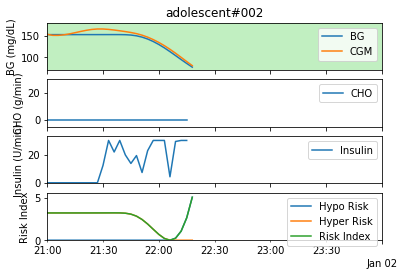

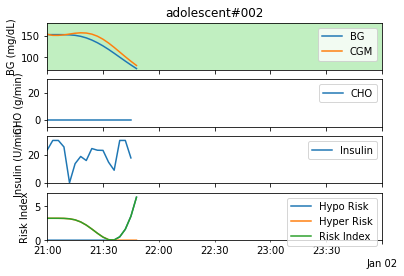

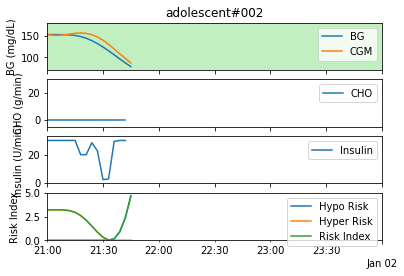

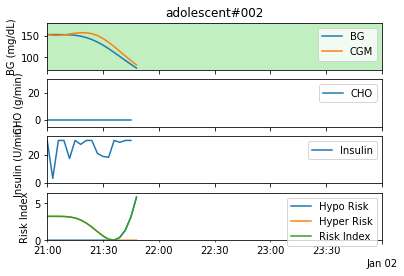

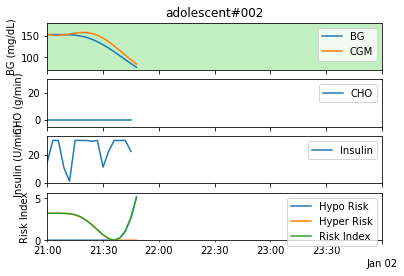

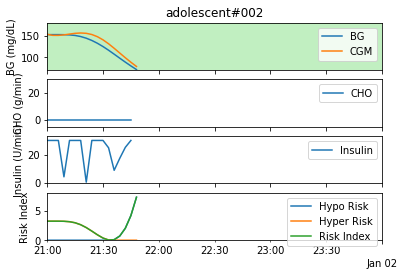

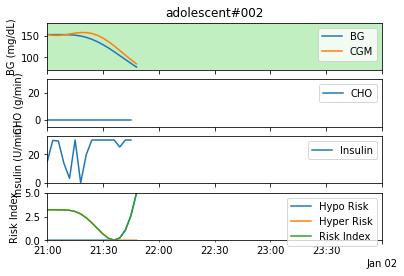

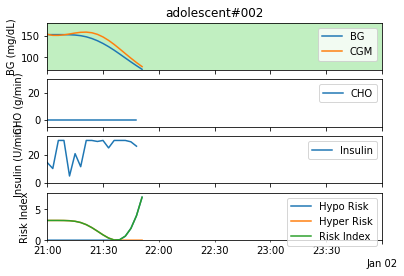

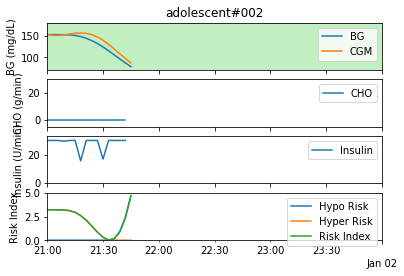

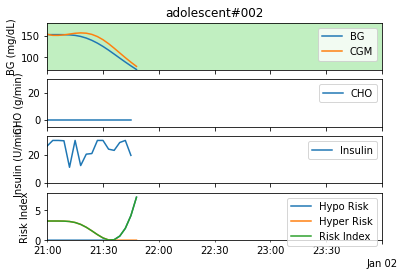

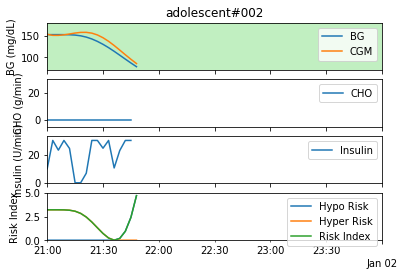

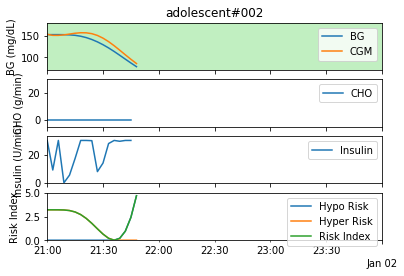

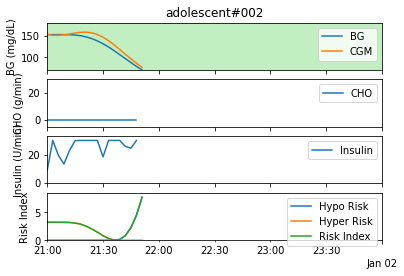

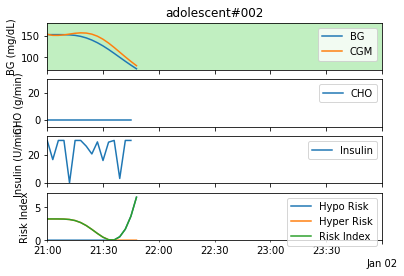

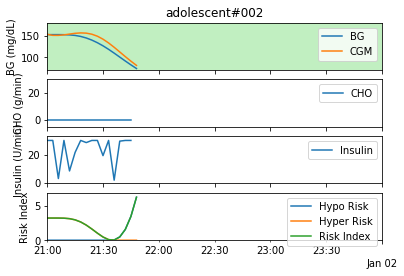

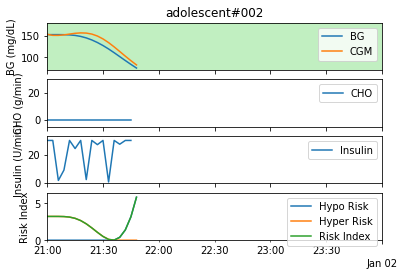

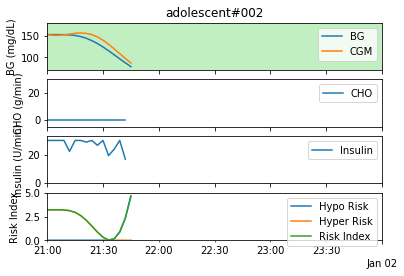

Error in callback <function flush_figures at 0x7f1e6d5e8820> (for post_execute):


KeyboardInterrupt: 

In [8]:
agent.train()

In [ ]:
#env.render()

In [ ]:
from gym.version import VERSION
print(VERSION)